# Controle Semafórico com Q-Learning

Notebook para treinar, salvar e testar um agente Q-Learning tabular para controle de semáforos.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque, defaultdict
import pickle
import os
from datetime import datetime

PROJECT_ROOT = os.path.abspath('..')
ASSETS_DIR = os.path.join(PROJECT_ROOT, "assets")
MODELS_DIR = os.path.join(PROJECT_ROOT, "models")
os.makedirs(ASSETS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

print("✅ Imports realizados")

✅ Imports realizados


In [2]:
class Vehicle:
    def __init__(self, id, is_bus=False):
        self.id = id
        self.is_bus = is_bus
        self.pos = -random.uniform(5, 25)
        self.wait_time = 0.0

class Lane:
    def __init__(self, name):
        self.name = name
        self.vehicles = deque()
        self.passed = 0

    def add_vehicles(self, n, start_id, bus_prob=0.0):
        for i in range(n):
            is_bus = random.random() < bus_prob
            v = Vehicle(start_id + i, is_bus=is_bus)
            self.vehicles.append(v)
        return n

    def queue_length(self):
        return len(self.vehicles)

    def step_logic(self, is_green, dt, discharge_rate):
        passed_now = 0
        waited_sum = 0.0
        
        if is_green:
            expected = discharge_rate * dt
            base = int(np.floor(expected))
            extra = 1 if random.random() < (expected - base) else 0
            capacity = base + extra

            for k in range(capacity):
                if not self.vehicles: break
                if self.vehicles[0].pos > -2: 
                    v = self.vehicles.popleft()
                    waited_sum += v.wait_time
                    self.passed += 1
                    passed_now += 1
        
        for i, veh in enumerate(self.vehicles):
            dist_to_next = 100
            if i > 0:
                dist_to_next = self.vehicles[i-1].pos - veh.pos - 2

            if is_green:
                move = min(1.5 * dt, 5.0)
            else:
                target = 0 if i == 0 else (self.vehicles[i-1].pos - 2)
                dist = target - veh.pos
                move = max(0, min(dist, 1.5 * dt))
            
            if i > 0 and move > dist_to_next:
                move = max(0, dist_to_next)
                
            veh.pos += move
            
            if move < 0.1:
                veh.wait_time += dt

        return passed_now, waited_sum

# Funções auxiliares
def ruido_sensor(valor_real, erro_max=0.15):
    if valor_real <= 0: return 0
    fator = 1 + random.uniform(-erro_max, erro_max)
    return max(0, int(valor_real * fator))

def gerar_fluxo_carros(taxa_media_minuto, tempo_decorrido_sec):
    lambda_poisson = (taxa_media_minuto / 60) * tempo_decorrido_sec
    return np.random.poisson(lambda_poisson)

def detectar_prioridade(probabilidade):
    return random.random() < probabilidade

def detectar_pedestre(probabilidade):
    return random.random() < probabilidade

print("✅ Classes base definidas")

✅ Classes base definidas


## Agente Q-Learning

### Discretização do Estado

Como Q-Learning usa **tabela**, precisamos discretizar estados contínuos:

- **Fila A**: `[0-2, 3-5, 6-10, 11-20, 21+]` → 5 bins
- **Fila B**: `[0-2, 3-5, 6-10, 11-20, 21+]` → 5 bins  
- **Fase**: `{A, B}` → 2 valores
- **Tempo na fase**: `[0-15s, 16-30s, 31-60s, 61+s]` → 4 bins

**Total de estados**: 5 × 5 × 2 × 4 = **200 estados discretos**

### Ações

- **0**: Manter verde atual
- **1**: Trocar para outra fase

### Recompensa

```python
r = -(tempo de espera + fila_A + fila_B)
```

Penaliza filas grandes → agente aprende a minimizar espera.

In [3]:
class QLearningController:
    def __init__(self, laneA, laneB, alpha=0.1, gamma=0.95, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.laneA = laneA
        self.laneB = laneB
        self.phase = 'A'
        self.phase_time = 0
        
        # Hiperparâmetros Q-Learning
        self.alpha = alpha          # Taxa de aprendizado
        self.gamma = gamma          # Fator de desconto
        self.epsilon = epsilon      # Taxa de exploração inicial
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        # Q-Table: defaultdict inicializa com 0
        self.q_table = defaultdict(lambda: np.zeros(2))  # 2 ações
        
        # Parâmetros de controle
        self.g_min = 16
        self.g_max = 90
        self.yellow_time = 3
        self.in_yellow = False
        self.yellow_timer = 0
        
        # Histórico
        self.green_times_log = []
        
    def discretize_state(self):
        """Converte estado contínuo em estado discreto (bins)"""
        qA = self.laneA.queue_length()
        qB = self.laneB.queue_length()
        
        # Bins para filas
        def bin_queue(q):
            if q <= 2: return 0
            elif q <= 5: return 1
            elif q <= 10: return 2
            elif q <= 20: return 3
            else: return 4
        
        # Bins para tempo na fase
        def bin_time(t):
            if t <= 15: return 0
            elif t <= 30: return 1
            elif t <= 60: return 2
            else: return 3
        
        qA_bin = bin_queue(qA)
        qB_bin = bin_queue(qB)
        phase_id = 0 if self.phase == 'A' else 1
        time_bin = bin_time(self.phase_time)
        
        return (qA_bin, qB_bin, phase_id, time_bin)

    def select_action(self, state, training=True):
        """ε-greedy: explora com prob ε, explota caso contrário"""
        if training and random.random() < self.epsilon:
            return random.randint(0, 1)  # Exploração
        else:
            return np.argmax(self.q_table[state])  # Exploitação

    def update_q(self, state, action, reward, next_state):
        """Atualiza Q-table (Bellman)"""
        current_q = self.q_table[state][action]
        max_next_q = np.max(self.q_table[next_state])
        
        # Q(s,a) ← Q(s,a) + α [r + γ max Q(s',a') - Q(s,a)]
        new_q = current_q + self.alpha * (reward + self.gamma * max_next_q - current_q)
        self.q_table[state][action] = new_q

    def step(self, dt, reward=0, training=True):
        """Executa um passo do controlador"""
        # Gerencia amarelo
        if self.in_yellow:
            self.yellow_timer += dt
            if self.yellow_timer >= self.yellow_time:
                self.green_times_log.append((self.phase, self.phase_time))
                self.phase = 'B' if self.phase == 'A' else 'A'
                self.phase_time = 0
                self.in_yellow = False
                self.yellow_timer = 0
            return self.phase
        
        state = self.discretize_state()
        action = self.select_action(state, training=training)
        
        # Ação 0: manter verde | Ação 1: trocar
        should_switch = (action == 1)
        
        if should_switch and self.phase_time >= self.g_min:
            self.in_yellow = True
            self.yellow_timer = 0
        elif self.phase_time >= self.g_max:
            self.in_yellow = True
            self.yellow_timer = 0
        else:
            self.phase_time += dt
        
        if training:
            next_state = self.discretize_state()
            self.update_q(state, action, reward, next_state)
        
        return self.phase

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

print("✅ Classe QLearningController definida")

✅ Classe QLearningController definida


## Treinamento

Treina o agente em múltiplos cenários de demanda.

In [4]:
# Parâmetros de treinamento
N_EPISODES = 20000
EPISODE_DURATION = 600  # 10 minutos
TAXA_ESCOAMENTO = 0.5
PROB_PRIORIDADE = 0.1

TRAINING_SCENARIOS = [
    {"media_A": 3, "media_B": 2, "weight": 0.1},
    {"media_A": 6, "media_B": 5, "weight": 0.15},
    {"media_A": 8, "media_B": 6, "weight": 0.25},
    {"media_A": 10, "media_B": 8, "weight": 0.15},
    {"media_A": 12, "media_B": 4, "weight": 0.1},
    {"media_A": 4, "media_B": 12, "weight": 0.1},
    {"media_A": 15, "media_B": 12, "weight": 0.1},
    {"media_A": 20, "media_B": 5, "weight": 0.05},
]

def train_qlearning_agent():
    agent = QLearningController(None, None)
    
    episode_rewards_history = []
    episode_avg_wait_history = []
    scenario_history = []
    
    print(f"Treinando {N_EPISODES} episódios...")
    
    for episode in range(N_EPISODES):
        weights = [s["weight"] for s in TRAINING_SCENARIOS]
        scenario = random.choices(TRAINING_SCENARIOS, weights=weights, k=1)[0]
        MEDIA_A = scenario["media_A"]
        MEDIA_B = scenario["media_B"]
        
        random.seed(episode)
        np.random.seed(episode)
        
        laneA = Lane('A')
        laneB = Lane('B')
        agent.laneA = laneA
        agent.laneB = laneB
        agent.phase = 'A'
        agent.phase_time = 0
        agent.in_yellow = False
        
        t = 0
        vehicle_id = 0
        episode_reward = 0
        total_wait = 0
        total_passed = 0
        
        while t < EPISODE_DURATION:
            chegA = gerar_fluxo_carros(MEDIA_A, 1)
            chegB = gerar_fluxo_carros(MEDIA_B, 1)
            laneA.add_vehicles(chegA, vehicle_id, bus_prob=PROB_PRIORIDADE)
            vehicle_id += chegA
            laneB.add_vehicles(chegB, vehicle_id, bus_prob=PROB_PRIORIDADE)
            vehicle_id += chegB
            
            qA_before = laneA.queue_length()
            qB_before = laneB.queue_length()
            
            current_phase = agent.step(1, reward=0, training=False)
            
            green_A = (current_phase == 'A')
            green_B = (current_phase == 'B')
            
            pA, wA = laneA.step_logic(green_A, 1, TAXA_ESCOAMENTO)
            pB, wB = laneB.step_logic(green_B, 1, TAXA_ESCOAMENTO)
            
            wait_time_this_step = wA + wB
            
            qA_after = laneA.queue_length()
            qB_after = laneB.queue_length()
            waiting_penalty = (qA_after + qB_after) * 0.1
            
            reward = -wait_time_this_step - waiting_penalty
            episode_reward += reward
            
            state = agent.discretize_state()
            action = 1 if agent.in_yellow else (0 if agent.phase_time < agent.g_min else np.argmax(agent.q_table[state]))
            next_state = agent.discretize_state()
            agent.update_q(state, action, reward, next_state)
            
            total_passed += (pA + pB)
            total_wait += (wA + wB)
            
            t += 1
        
        agent.decay_epsilon()
        
        avg_wait = total_wait / max(1, total_passed)
        episode_rewards_history.append(episode_reward)
        episode_avg_wait_history.append(avg_wait)
        scenario_history.append(f"{MEDIA_A}+{MEDIA_B}")
        
        if (episode + 1) % 1000 == 0:
            recent_wait = np.mean(episode_avg_wait_history[-500:])
            recent_reward = np.mean(episode_rewards_history[-500:])
            print(f"Ep {episode+1}/{N_EPISODES} | ε={agent.epsilon:.3f} | Espera(média 500): {recent_wait:.2f}s | Recompensa(média 500): {recent_reward:.1f} | Estados: {len(agent.q_table)}")

    print("Treinamento concluído.")
    print(f"Estados explorados: {len(agent.q_table)}")
    print(f"Epsilon final: {agent.epsilon:.4f}")
    print(f"Espera média (últimos 1000): {np.mean(episode_avg_wait_history[-1000:]):.2f}s")
    
    return agent, episode_rewards_history, episode_avg_wait_history, scenario_history

print("🚀 Iniciando treinamento...")
trained_agent, rewards_hist, waits_hist, scenarios_hist = train_qlearning_agent()

# Converte defaultdict para dict (pickle)
trained_agent.q_table = dict(trained_agent.q_table)

now = datetime.now()
model_filename = f'qlearning_agent_{now.strftime("%Y%m%d_%H%M%S")}_10k.pkl'
with open(os.path.join(MODELS_DIR, model_filename), 'wb') as f:
    pickle.dump(trained_agent, f)
print(f"Modelo salvo em {MODELS_DIR}/{model_filename}")

# Além do arquivo com timestamp, salva um "default" fixo:
default_path = os.path.join(MODELS_DIR, "qlearning_agent_default.pkl")
with open(default_path, "wb") as f:
    pickle.dump(trained_agent, f)
print(f"✅ Modelo default salvo em {default_path}")

🚀 Iniciando treinamento...
Treinando 20000 episódios...
Ep 1000/20000 | ε=0.010 | Espera(média 500): 11.31s | Recompensa(média 500): -2180.5 | Estados: 153
Ep 2000/20000 | ε=0.010 | Espera(média 500): 12.90s | Recompensa(média 500): -2460.7 | Estados: 170
Ep 3000/20000 | ε=0.010 | Espera(média 500): 9.35s | Recompensa(média 500): -1928.3 | Estados: 176
Ep 4000/20000 | ε=0.010 | Espera(média 500): 9.82s | Recompensa(média 500): -2018.4 | Estados: 178
Ep 5000/20000 | ε=0.010 | Espera(média 500): 10.77s | Recompensa(média 500): -2007.2 | Estados: 180
Ep 6000/20000 | ε=0.010 | Espera(média 500): 11.07s | Recompensa(média 500): -2140.7 | Estados: 180
Ep 7000/20000 | ε=0.010 | Espera(média 500): 11.74s | Recompensa(média 500): -2245.1 | Estados: 180
Ep 8000/20000 | ε=0.010 | Espera(média 500): 10.50s | Recompensa(média 500): -1976.5 | Estados: 182
Ep 9000/20000 | ε=0.010 | Espera(média 500): 11.02s | Recompensa(média 500): -2177.8 | Estados: 183
Ep 10000/20000 | ε=0.010 | Espera(média 500): 

## Curvas de aprendizado

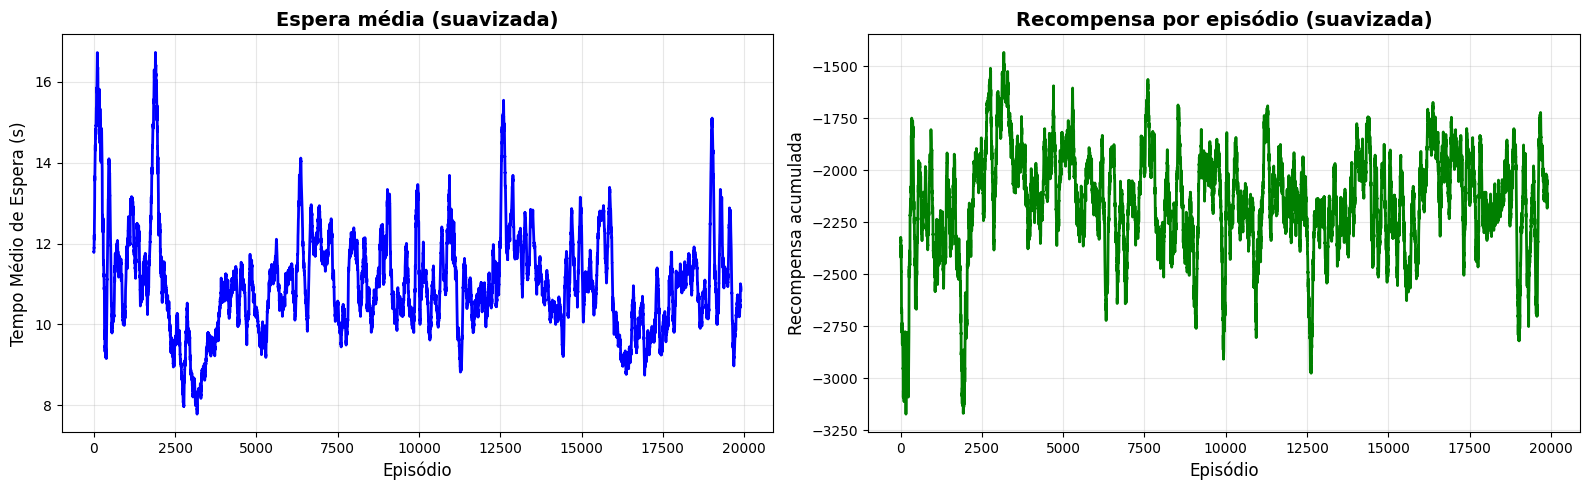

Espera inicial: 9.01s
Espera final (média últimos 100): 10.84s


In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

window = 100
smoothed_waits = np.convolve(waits_hist, np.ones(window)/window, mode='valid')

ax1.plot(smoothed_waits, color='blue', linewidth=2)
ax1.set_xlabel('Episódio', fontsize=12)
ax1.set_ylabel('Tempo Médio de Espera (s)', fontsize=12)
ax1.set_title('Espera média (suavizada)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

smoothed_rewards = np.convolve(rewards_hist, np.ones(window)/window, mode='valid')

ax2.plot(smoothed_rewards, color='green', linewidth=2)
ax2.set_xlabel('Episódio', fontsize=12)
ax2.set_ylabel('Recompensa acumulada', fontsize=12)
ax2.set_title('Recompensa por episódio (suavizada)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(ASSETS_DIR, 'qlearning_training.png'), dpi=150)
plt.show()

print(f"Espera inicial: {waits_hist[0]:.2f}s")
print(f"Espera final (média últimos 100): {np.mean(waits_hist[-100:]):.2f}s")

## Carregar e testar modelo treinado

In [6]:
# Tenta encontrar automaticamente o último modelo treinado em ODELS_DIR.
# Se não encontrar nenhum .pkl, mostra aviso e evita quebrar o notebook.

model_files = [
    f for f in os.listdir(MODELS_DIR)
    if f.startswith('qlearning_agent_') and f.endswith('.pkl')
]

if not model_files:
    print("⚠️ Nenhum arquivo de modelo encontrado em:", MODELS_DIR)
    print("   Rode primeiro a célula de treinamento para gerar um .pkl (train_qlearning_agent).")
    loaded_agent = None
else:
    # Ordena por nome (timestamp faz parte do nome) e pega o último
    model_files.sort()
    latest_model = model_files[-1]
    model_path = os.path.join(MODELS_DIR, latest_model)

    with open(model_path, 'rb') as f:
        loaded_agent = pickle.load(f)

    if not isinstance(loaded_agent.q_table, defaultdict):
        q_table_backup = loaded_agent.q_table.copy()
        loaded_agent.q_table = defaultdict(lambda: np.zeros(2))
        loaded_agent.q_table.update(q_table_backup)

    print(f"✅ Modelo carregado de {model_path}")
    print(f"📊 Q-table size: {len(loaded_agent.q_table)} estados")
    print(f"🎯 Epsilon final: {loaded_agent.epsilon:.4f}")

✅ Modelo carregado de /home/guilhermehigino/Projects/semaforo-ia/models/qlearning_agent_default.pkl
📊 Q-table size: 189 estados
🎯 Epsilon final: 0.0100


In [7]:
# Episódio de teste simples
def test_agent(agent, seed=42, MEDIA_A=8, MEDIA_B=6):
    random.seed(seed)
    np.random.seed(seed)
    
    laneA = Lane('A')
    laneB = Lane('B')
    agent.laneA = laneA
    agent.laneB = laneB
    agent.phase = 'A'
    agent.phase_time = 0
    agent.in_yellow = False
    
    t = 0
    vehicle_id = 0
    total_wait = 0
    total_passed = 0
    queue_history = []
    
    while t < EPISODE_DURATION:
        chegA = gerar_fluxo_carros(MEDIA_A, 1)
        chegB = gerar_fluxo_carros(MEDIA_B, 1)
        laneA.add_vehicles(chegA, vehicle_id, bus_prob=PROB_PRIORIDADE)
        vehicle_id += chegA
        laneB.add_vehicles(chegB, vehicle_id, bus_prob=PROB_PRIORIDADE)
        vehicle_id += chegB
        
        qA = laneA.queue_length()
        qB = laneB.queue_length()
        queue_history.append({'t': t, 'qA': qA, 'qB': qB, 'phase': agent.phase})
        
        reward = -(qA + qB)
        current_phase = agent.step(1, reward=reward, training=False)
        
        green_A = (current_phase == 'A')
        green_B = (current_phase == 'B')
        
        pA, wA = laneA.step_logic(green_A, 1, TAXA_ESCOAMENTO)
        pB, wB = laneB.step_logic(green_B, 1, TAXA_ESCOAMENTO)
        
        total_passed += (pA + pB)
        total_wait += (wA + wB)
        
        t += 1
    
    avg_wait = total_wait / max(1, total_passed)
    return avg_wait, queue_history

avg_wait_test, queue_hist = test_agent(loaded_agent)

print("Resultado do teste:")
print(f"Tempo médio de espera: {avg_wait_test:.2f}s")

Resultado do teste:
Tempo médio de espera: 7.68s


## Visualização do comportamento no teste

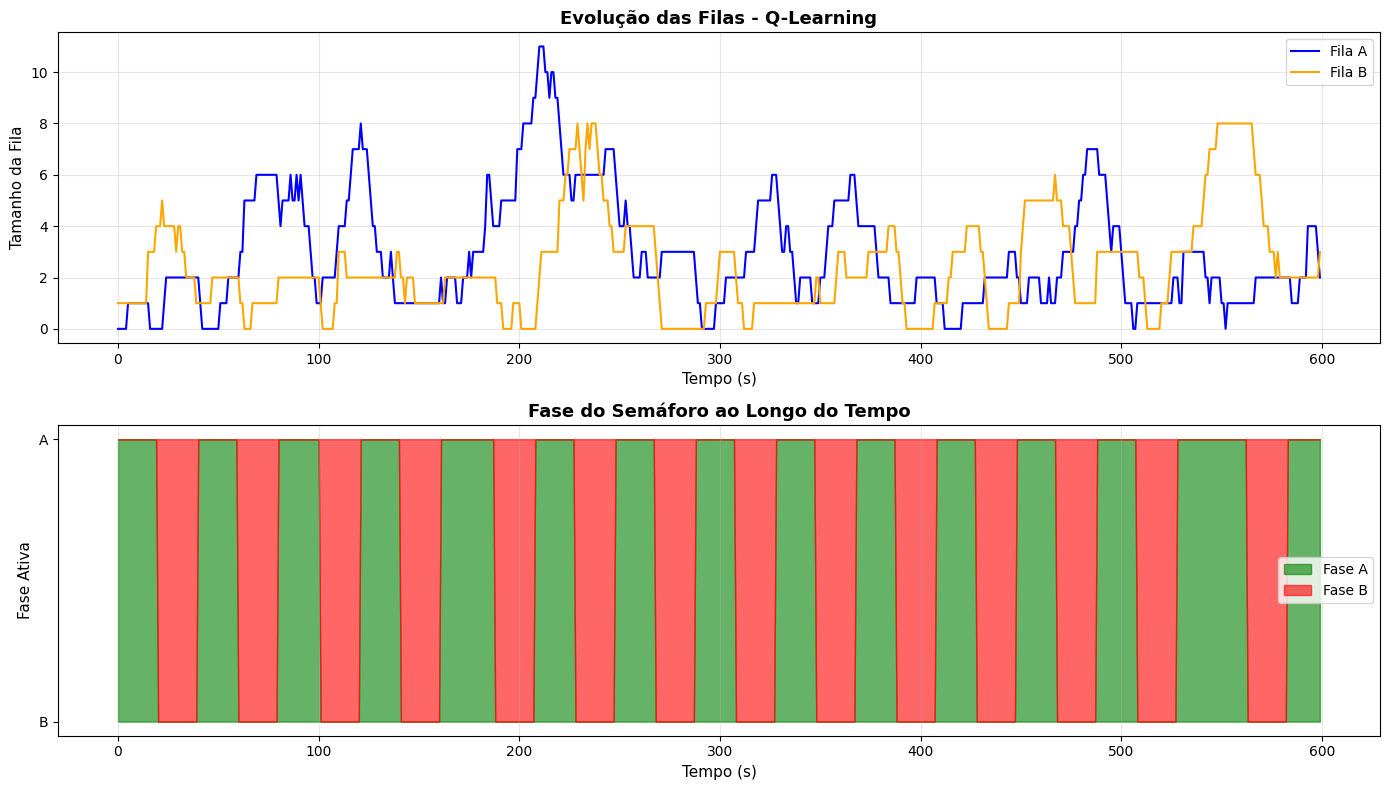

Gráficos salvos.


In [8]:
import pandas as pd

df_queue = pd.DataFrame(queue_hist)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Filas
ax1.plot(df_queue['t'], df_queue['qA'], label='Fila A', color='blue', linewidth=1.5)
ax1.plot(df_queue['t'], df_queue['qB'], label='Fila B', color='orange', linewidth=1.5)
ax1.set_xlabel('Tempo (s)', fontsize=11)
ax1.set_ylabel('Tamanho da Fila', fontsize=11)
ax1.set_title('Evolução das Filas - Q-Learning', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Fase
phase_numeric = df_queue['phase'].map({'A': 1, 'B': 0})
ax2.fill_between(df_queue['t'], 0, phase_numeric, alpha=0.6, color='green', label='Fase A')
ax2.fill_between(df_queue['t'], phase_numeric, 1, alpha=0.6, color='red', label='Fase B')
ax2.set_xlabel('Tempo (s)', fontsize=11)
ax2.set_ylabel('Fase Ativa', fontsize=11)
ax2.set_yticks([0, 1])
ax2.set_yticklabels(['B', 'A'])
ax2.set_title('Fase do Semáforo ao Longo do Tempo', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(os.path.join(ASSETS_DIR, 'qlearning_test_behavior.png'), dpi=150)
plt.show()

print("Gráficos salvos.")

## Teste em múltiplos cenários

In [9]:
def test_multiple_scenarios(agent):
    scenarios = [
        {"name": "Balanceado", "media_A": 8, "media_B": 6, "desc": "Padrão"},
        {"name": "Rush Hour", "media_A": 15, "media_B": 12, "desc": "Alto tráfego"},
        {"name": "Assimétrico A", "media_A": 12, "media_B": 4, "desc": "Via A dominante"},
        {"name": "Assimétrico B", "media_A": 4, "media_B": 12, "desc": "Via B dominante"},
        {"name": "Baixo Tráfego", "media_A": 3, "media_B": 2, "desc": "Tranquilo"},
        {"name": "Pico Extremo A", "media_A": 20, "media_B": 5, "desc": "Pico A"},
        {"name": "Pico Extremo B", "media_A": 5, "media_B": 20, "desc": "Pico B"},
    ]
    
    results = []
    
    print("Testando múltiplos cenários...")
    
    for scenario in scenarios:
        random.seed(42)
        np.random.seed(42)
        
        laneA = Lane('A')
        laneB = Lane('B')
        agent.laneA = laneA
        agent.laneB = laneB
        agent.phase = 'A'
        agent.phase_time = 0
        agent.in_yellow = False
        
        t = 0
        vehicle_id = 0
        total_wait = 0
        total_passed = 0
        max_queue_A = 0
        max_queue_B = 0
        
        while t < EPISODE_DURATION:
            chegA = gerar_fluxo_carros(scenario["media_A"], 1)
            chegB = gerar_fluxo_carros(scenario["media_B"], 1)
            laneA.add_vehicles(chegA, vehicle_id, bus_prob=PROB_PRIORIDADE)
            vehicle_id += chegA
            laneB.add_vehicles(chegB, vehicle_id, bus_prob=PROB_PRIORIDADE)
            vehicle_id += chegB
            
            qA = laneA.queue_length()
            qB = laneB.queue_length()
            max_queue_A = max(max_queue_A, qA)
            max_queue_B = max(max_queue_B, qB)
            
            reward = -(qA + qB)
            current_phase = agent.step(1, reward=reward, training=False)
            
            green_A = (current_phase == 'A')
            green_B = (current_phase == 'B')
            
            pA, wA = laneA.step_logic(green_A, 1, TAXA_ESCOAMENTO)
            pB, wB = laneB.step_logic(green_B, 1, TAXA_ESCOAMENTO)
            
            total_passed += (pA + pB)
            total_wait += (wA + wB)
            
            t += 1
        
        avg_wait = total_wait / max(1, total_passed)
        
        results.append({
            "scenario": scenario["name"],
            "media_A": scenario["media_A"],
            "media_B": scenario["media_B"],
            "avg_wait": avg_wait,
            "max_queue_A": max_queue_A,
            "max_queue_B": max_queue_B,
            "total_passed": total_passed,
            "desc": scenario["desc"]
        })
        
        print(f"{scenario['name']:15s} | Espera: {avg_wait:5.2f}s | Fila máx A={max_queue_A:3d} B={max_queue_B:3d} | Processados: {total_passed:3d}")
    
    return pd.DataFrame(results)

df_scenarios = test_multiple_scenarios(loaded_agent)

print("Resumo:")
print(f"Espera média geral: {df_scenarios['avg_wait'].mean():.2f}s")
print(f"Melhor cenário: {df_scenarios.loc[df_scenarios['avg_wait'].idxmin(), 'scenario']} ({df_scenarios['avg_wait'].min():.2f}s)")
print(f"Pior cenário: {df_scenarios.loc[df_scenarios['avg_wait'].idxmax(), 'scenario']} ({df_scenarios['avg_wait'].max():.2f}s)")

Testando múltiplos cenários...
Balanceado      | Espera:  7.68s | Fila máx A= 11 B=  8 | Processados: 145
Rush Hour       | Espera: 16.93s | Fila máx A= 29 B= 16 | Processados: 252
Assimétrico A   | Espera:  9.64s | Fila máx A= 12 B=  6 | Processados: 160
Assimétrico B   | Espera: 14.23s | Fila máx A=  7 B= 20 | Processados: 154
Baixo Tráfego   | Espera:  4.42s | Fila máx A=  4 B=  5 | Processados:  45
Pico Extremo A  | Espera: 16.92s | Fila máx A= 45 B=  8 | Processados: 213
Pico Extremo B  | Espera: 41.79s | Fila máx A=  9 B= 69 | Processados: 194
Resumo:
Espera média geral: 15.95s
Melhor cenário: Baixo Tráfego (4.42s)
Pior cenário: Pico Extremo B (41.79s)


## Visualização dos cenários

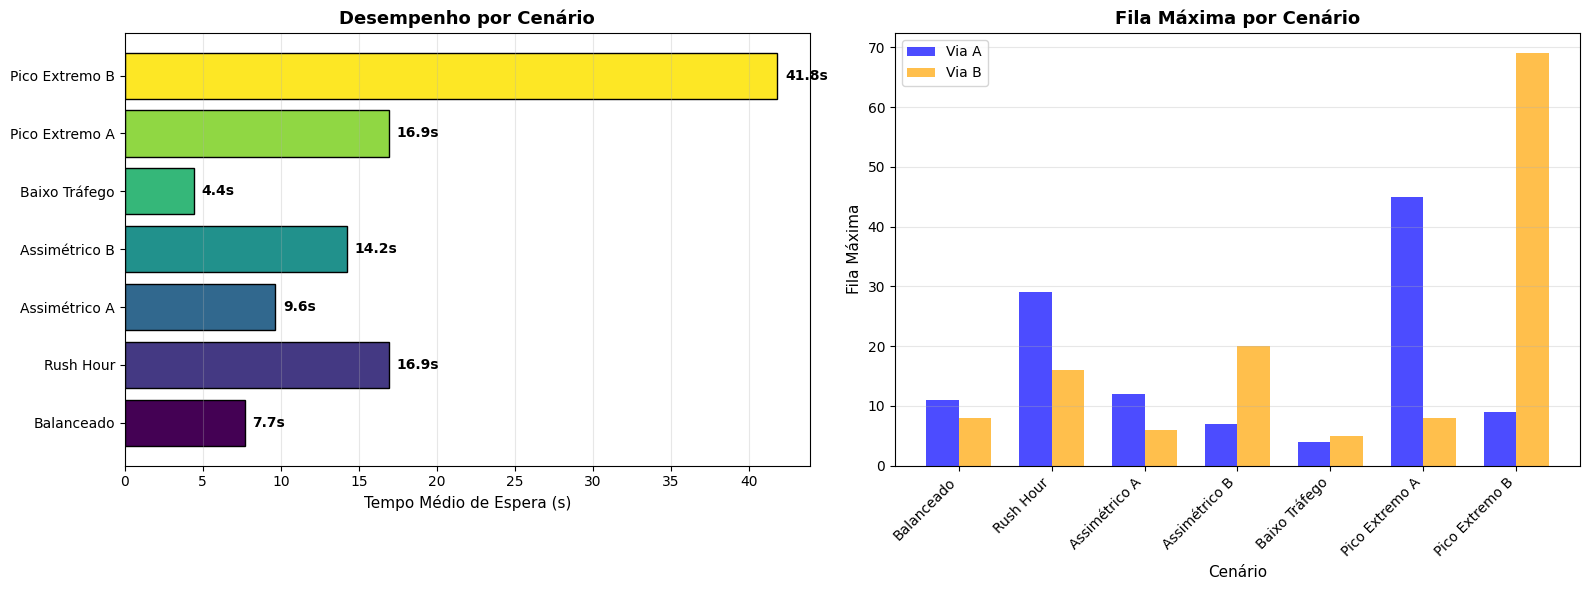

Análise de cenários concluída.


In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

colors = plt.cm.viridis(np.linspace(0, 1, len(df_scenarios)))
bars = ax1.barh(df_scenarios['scenario'], df_scenarios['avg_wait'], color=colors, edgecolor='black')

for bar, val in zip(bars, df_scenarios['avg_wait']):
    ax1.text(val + 0.5, bar.get_y() + bar.get_height()/2,
             f'{val:.1f}s', va='center', fontsize=10, fontweight='bold')

ax1.set_xlabel('Tempo Médio de Espera (s)', fontsize=11)
ax1.set_title('Desempenho por Cenário', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

x = np.arange(len(df_scenarios))
width = 0.35

bars1 = ax2.bar(x - width/2, df_scenarios['max_queue_A'], width, label='Via A', color='blue', alpha=0.7)
bars2 = ax2.bar(x + width/2, df_scenarios['max_queue_B'], width, label='Via B', color='orange', alpha=0.7)

ax2.set_xlabel('Cenário', fontsize=11)
ax2.set_ylabel('Fila Máxima', fontsize=11)
ax2.set_title('Fila Máxima por Cenário', fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(df_scenarios['scenario'], rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(ASSETS_DIR, 'qlearning_multiple_scenarios.png'), dpi=150)
plt.show()

print("Análise de cenários concluída.")

## Robustez a ruído nos sensores

Testando robustez a ruído...
Ruído:    0% | Espera média: 7.68s
Ruído:   10% | Espera média: 10.26s
Ruído:   20% | Espera média: 10.26s
Ruído:   30% | Espera média: 10.74s


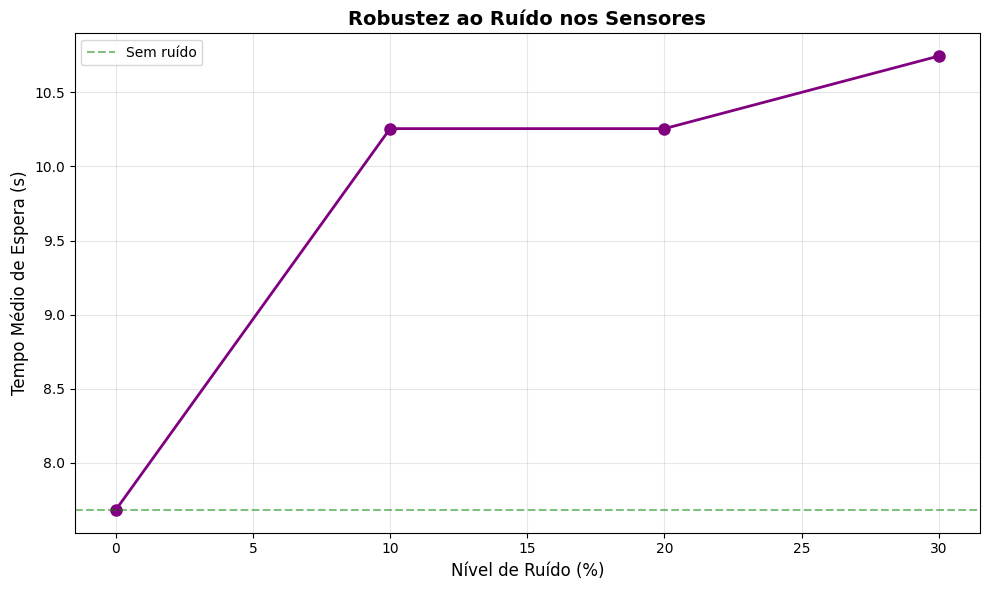

Degradação com 30% de ruído: 39.9%


In [11]:
def test_with_sensor_noise(agent, noise_levels=[0.0, 0.1, 0.2, 0.3], MEDIA_A=8, MEDIA_B=6):
    results = []
    
    print("Testando robustez a ruído...")
    
    for noise in noise_levels:
        random.seed(42)
        np.random.seed(42)
        
        laneA = Lane('A')
        laneB = Lane('B')
        agent.laneA = laneA
        agent.laneB = laneB
        agent.phase = 'A'
        agent.phase_time = 0
        agent.in_yellow = False
        
        t = 0
        vehicle_id = 0
        total_wait = 0
        total_passed = 0
        
        while t < EPISODE_DURATION:
            chegA = gerar_fluxo_carros(MEDIA_A, 1)
            chegB = gerar_fluxo_carros(MEDIA_B, 1)
            laneA.add_vehicles(chegA, vehicle_id, bus_prob=PROB_PRIORIDADE)
            vehicle_id += chegA
            laneB.add_vehicles(chegB, vehicle_id, bus_prob=PROB_PRIORIDADE)
            vehicle_id += chegB
            
            qA_real = laneA.queue_length()
            qB_real = laneB.queue_length()
            
            if noise > 0:
                class FakeLane:
                    def __init__(self, q):
                        self._q = q
                    def queue_length(self):
                        return self._q
                
                qA_noisy = ruido_sensor(qA_real, noise)
                qB_noisy = ruido_sensor(qB_real, noise)
                
                agent.laneA = FakeLane(qA_noisy)
                agent.laneB = FakeLane(qB_noisy)
            
            reward = -(qA_real + qB_real)
            current_phase = agent.step(1, reward=reward, training=False)
            
            # restaura lanes reais
            agent.laneA = laneA
            agent.laneB = laneB
            
            green_A = (current_phase == 'A')
            green_B = (current_phase == 'B')
            
            pA, wA = laneA.step_logic(green_A, 1, TAXA_ESCOAMENTO)
            pB, wB = laneB.step_logic(green_B, 1, TAXA_ESCOAMENTO)
            
            total_passed += (pA + pB)
            total_wait += (wA + wB)
            
            t += 1
        
        avg_wait = total_wait / max(1, total_passed)
        results.append({"noise": noise * 100, "avg_wait": avg_wait})
        
        print(f"Ruído: {noise*100:4.0f}% | Espera média: {avg_wait:.2f}s")
    
    return pd.DataFrame(results)

df_noise = test_with_sensor_noise(loaded_agent)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df_noise['noise'], df_noise['avg_wait'], marker='o', linewidth=2, markersize=8, color='purple')
ax.set_xlabel('Nível de Ruído (%)', fontsize=12)
ax.set_ylabel('Tempo Médio de Espera (s)', fontsize=12)
ax.set_title('Robustez ao Ruído nos Sensores', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.axhline(y=avg_wait_test, color='green', linestyle='--', alpha=0.5, label='Sem ruído')
ax.legend()

plt.tight_layout()
plt.savefig(os.path.join(ASSETS_DIR, 'qlearning_robustness.png'), dpi=150)
plt.show()

degradation = ((df_noise['avg_wait'].iloc[-1] - df_noise['avg_wait'].iloc[0]) / df_noise['avg_wait'].iloc[0]) * 100
print(f"Degradação com {df_noise['noise'].iloc[-1]:.0f}% de ruído: {degradation:.1f}%")

## Resumo

- Q-Learning tabular treinado com múltiplos cenários.
- Modelo salvo em `models/` e gráficos em `assets/`.
- Código focado apenas em implementação e métricas, sem textos longos.